# First order methods on regression models

    Lab 2 : Optimization for Machine Learning, AMMI Master's in Machine Intelligence

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT


- **Each** student must send their jupyter notebook solutions **before the 18th of February at 23:55**  to **gowerrobert@gmail.com**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Lionel"
ln1 = "NGOUPEYOU TONDJI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1])) + ".ipynb"
print(filename)

lab1_ngoupeyou tondji_lionel.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

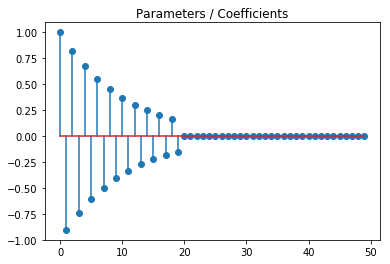

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [6]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    
    result = np.sign(x) * np.maximum(np.abs(x) - s, 0.)
    return result # TODO
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    result = norm(x, ord = 1)
    return result * s # TODO

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x"""    
    return x/(1+s) # TODO
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    result = norm(x)
    return 0.5*result*s # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

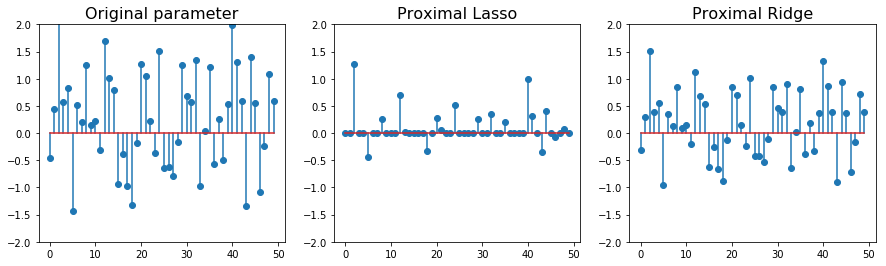

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).
         
         Answer :  Lasso method overcomes the disadvantage of Ridge regression by not only punishing high values of the coefficients s but actually setting them to zero if they are not relevant (Features selection). Therefore, you might end up with fewer features included in the model than you started with, which is a huge advantage.
  </li>
    </ul>
</div>

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [8]:
from scipy.optimize import check_grad

global A1, b1, A2, b2

A1, b1 = simu_linreg(coefs, n_samples=1000, corr=0.5)
A2, b2 = simu_logreg(coefs, n_samples=1000, corr=0.5)

In [9]:
def loss_linreg(x):
    return 0.5 * norm(b1 - A1.dot(x)) ** 2 / n_samples

def grad_linreg(x):
    """Leas-squares gradient"""
    # TODO
    return (1/n_samples) * (A1.T @ ((A1 @ x) - b1))
    # pass

def loss_logreg(x):
    u = b2 * A2.dot(x)
    return np.sum(np.log(1 + np.exp(-u))) / n_samples

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    u = b2 * A2.dot(x)
    g = np.zeros(n_features)
    for i in range(n_samples):
        g += (-b2[i]*A2[i])/((1 + np.exp(u[i]))*n_samples)
    return  g
    # pass

In [10]:
# TO BE COMPLETED

# Precision of the gradient in the linear regression case
check_grad(loss_linreg, grad_linreg,x)
print('Precision of the gradient in the linear regression case :  ', check_grad(loss_linreg, grad_linreg,x))

# Precision of the gradient in the logistic regression case
check_grad(loss_logreg, grad_logreg,x)
print('Precision of the gradient in the logistic regression case :  ', check_grad(loss_logreg, grad_logreg,x))


Precision of the gradient in the linear regression case :   1.930333343624755e-06
Precision of the gradient in the logistic regression case :   1.9819498044405066e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` below that implements the 
  ISTA (Proximal Gradient Descent) algorithm</li>
    <li> BONUS QUESTION:  Implement FISTA (Accelerated Proximal 
  Gradient Descent) algorithm as described at the bottom
    </ul>
</div>

In [25]:
# TO BE COMPLETED

def lip_linreg(A1):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    return (np.linalg.norm(A1)**2)/ n_samples
    # pass
    
def lip_logreg(A2):
    """Lipschitz constant for logistic loss"""    
    # TODO
    return (np.linalg.norm(A2)**2)/ (4*n_samples)
    # pass
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A1.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    
   # past_w = 0
    for k in range(n_iter + 1):

        #### TODO ####
        
        xnew = prox_g(x - step * grad_f(x), s*step)
        x = xnew
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

Try and implement the FISTA algorithm (detailed in maths below)

FISTA Algorithm:
$$\begin{array}{l}
\mbox{Set } w^1=0=z^1, \beta^1 =1\\
\mbox{for }t=1,2,3, \ldots, T \quad  \\
\qquad \displaystyle w^{t+1} = \mbox{prox}_{\left. \lambda R \right/ \mathcal{L}}\left( z^t - \frac{1}{\mathcal{L}} \nabla L(z^t)\right) \\
\qquad \displaystyle \beta^{t+1} = \frac{1+\sqrt{1+4(\beta^t)^2}}{2}\\
\qquad \displaystyle  z^{t+1} = w^{t+1} + \frac{\beta^t -1}{\beta^{t+1}} (w^{t+1} -w^{t})\\
\mbox{Output } w^{T+1}
\end{array}$$

In [26]:
# TO BE COMPLETED

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A1.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    
    x, z , beta = np.zeros(n_features), np.zeros(n_features), 1
    for k in range(n_iter + 1):

        #### TODO ####
        
        newx = prox_g(z - step * grad_f(z), s*step)
        newbeta = 0.5 * (1 + np.sqrt(1 + 4 *(beta**2)))
        newz = newx + (beta-1)*(newx - x)/(newbeta) 
        x = newx
        beta = newbeta
        z = newz

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [27]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [28]:
x_t, objectives1_fista, errors_fista = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step= 1/lip_linreg(A1), s=s, n_iter=100000, verbose=False)
m = min(objectives1_fista)

In [29]:
# fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step= 1/lip_linreg(A1), s=s, n_iter=1000)

x_ista, objectives_ista, errors_ista = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_linreg(A1), s=s, n_iter=1000, verbose=False)
x_fista, objectives_fista, errors_fista = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_linreg(A1), s=s, n_iter=1000, verbose=False)

Text(0, 0.5, 'objctive value in log scale')

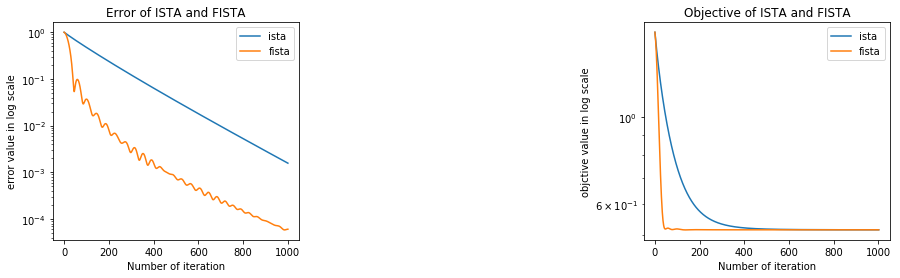

In [30]:
plt.figure(figsize=(15.0,4.0))
##############################################
# Plot of the error values
plt.subplot(1,3,1)
plt.plot(errors_ista, label = 'ista')
plt.plot(errors_fista, label = 'fista')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Error of ISTA and FISTA')
plt.xlabel("Number of iteration")
plt.ylabel("error value in log scale")

##############################################
# Plot of the objective values
plt.subplot(1,3,3)
plt.plot(objectives_ista, label = 'ista')
plt.plot(objectives_fista, label = 'fista')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Objective of ISTA and FISTA')
plt.xlabel("Number of iteration")
plt.ylabel("objctive value in log scale")

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.
        
         Answer :  L1 regularization adds a penalty α∑|wi| to the loss function (L1-norm). Since each non-zero coefficient adds to the penalty, it forces weak features to have zero as coefficients. Thus L1 regularization produces sparse solutions, inherently performing feature selection.however that L1 regularized regression is unstable in a similar way as unregularized linear models are, meaning that the coefficients (and thus feature ranks) can vary significantly even on small data changes when there are correlated features in the data. 
                   L2 regularization (called ridge regression for linear regression) adds the L2 norm penalty (α∑wi^2) to the loss function. Since the coefficients are squared in the penalty expression, it has a different effect from L1-norm, namely it forces the coefficient values to be spread out more equally. For correlated features, it means that they tend to get similar coefficients.
         
   </li>
         
   <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.
                        
        Answer :   In  linear regression and logistic regression. when the level of ridge penalization is very small, our model tend to have low bias, high variance whereas when the the level of ridge penalization is very small, our model tend to have high bias, low variance. A super important fact we need to notice about ridge regression is that it enforces the level of ridge penalization coefficients to be lower, but it does not enforce them to be zero. That is, it will not get rid of irrelevant features but rather minimize their impact on the trained model.

</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain
    
    Answer : According to the graph below, we can notice that the performance of the optimization algorithms for ridge penalizations is always better than the performance of the optimization   algorithms for lasso penalizations both with ISTA and FISTA algorithms
</li>
    </ul>
</div>

(-2, 2)

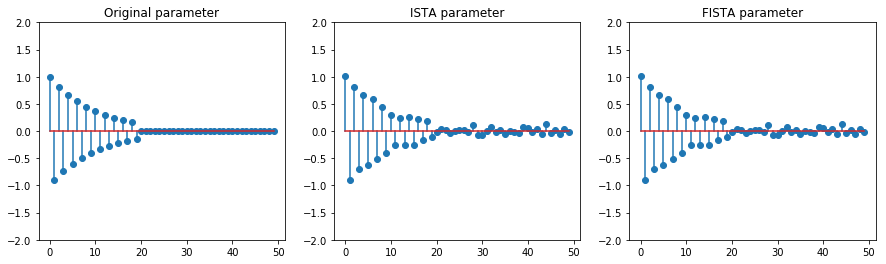

In [31]:
plt.figure(figsize=(15.0,4.0))
plt.subplot(1,3,1)
plt.stem(coefs)
plt.title('Original parameter')
plt.ylim([-2,2])
plt.subplot(1,3,2)
plt.stem(x_ista)
plt.title('ISTA parameter')
plt.ylim([-2,2])
plt.subplot(1,3,3)
plt.stem(x_fista)
plt.title('FISTA parameter')
plt.ylim([-2,2])

# In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.



In [32]:
# x_ista, objectives_ista, errors_ista = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_linreg(A1), s=s, n_iter=1000, verbose=False)
# x_fista, objectives_fista, errors_fista = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_linreg(A1), s=s, n_iter=1000, verbose=False)

# In linear regression and logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms. Explain.

In [33]:
# s1 = 10^(-2)
# s2 = 10^(2)

# _, objectives_fista_linreg, errors_fista_linreg = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_linreg(A1), s=s1, n_iter=1000, verbose=False)
# _, objectives_fista_linreg1, errors_fista_linreg1 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_linreg(A1), s=s2, n_iter=1000, verbose=False)

# plt.plot(errors_fista_linreg, label = 'Linear Regression ( s1 = 10^(-6))')
# plt.plot(errors_fista_linreg1, label = 'Linear Regression ( s2 = 10^(6))')
# plt.yscale('log')
# plt.legend(loc='best')
# plt.title('Error of FISTA (s1 vs s2)', fontsize=11)
# plt.xlabel("Number of iteration", fontsize=7)
# plt.ylabel("error value(log scale)")

In [34]:
# s1 = 10^(-6)
# s2 = 10^(6)

# _, objectives_fista_logreg, errors_fista_logreg = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_logreg(A1), s=s1, n_iter=1000, verbose=False)
# _, objectives_fista_logreg, errors_fista_logreg = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_logreg(A1), s=s2, n_iter=1000, verbose=False)
# plt.plot(errors_ista_linreg, label = 'Ridge penalization')
# plt.plot(errors_ista_linreg1, label = 'Lasso penalization')
# plt.yscale('log')
# plt.legend(loc='best')
# plt.title('Error of ISTA (Ridge vs Lasso)', fontsize=11)
# plt.xlabel("Number of iteration", fontsize=7)
# plt.ylabel("error value(log scale)")

# In linear regression and logistic regression, compare the performance of the optimization algorithms for ridge and lasso penalizations. Explain

## Linear Regression

Text(0, 0.5, 'objctive value(log scale)')

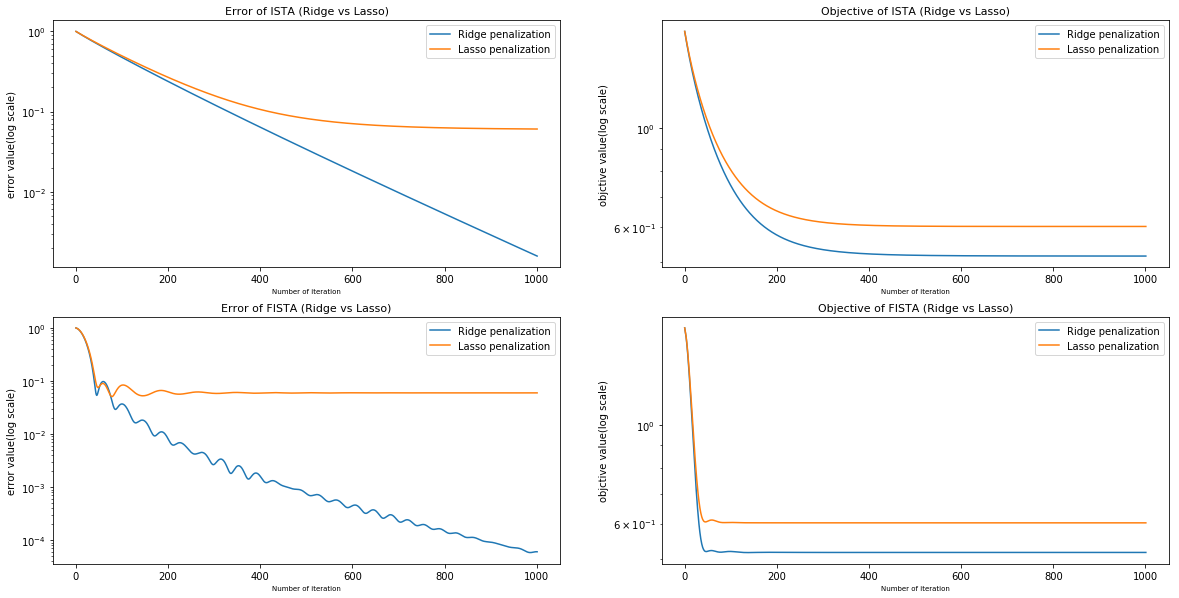

In [35]:
# ista
_, objectives_ista_linreg, errors_ista_linreg = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_linreg(A1), s=s, n_iter=1000, verbose=False)
_, objectives_ista_linreg1, errors_ista_linreg1 = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, x_true=x_t, step= 1/lip_linreg(A1), s=s, n_iter=1000, verbose=False)

# fista
_, objectives_fista_linreg2, errors_fista_linreg2 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_linreg(A1), s=s, n_iter=1000, verbose=False)
_, objectives_fista_linreg3, errors_fista_linreg3 = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, x_true=x_t, step= 1/lip_linreg(A1), s=s, n_iter=1000, verbose=False)


plt.figure(figsize=(20,10))
##############################################
# Plot of the error values
plt.subplot(2,2,1)
plt.plot(errors_ista_linreg, label = 'Ridge penalization')
plt.plot(errors_ista_linreg1, label = 'Lasso penalization')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Error of ISTA (Ridge vs Lasso)', fontsize=11)
plt.xlabel("Number of iteration", fontsize=7)
plt.ylabel("error value(log scale)")

##############################################
# Plot of the objective values
plt.subplot(2,2,2)
plt.plot(objectives_ista_linreg, label = 'Ridge penalization')
plt.plot(objectives_ista_linreg1, label = 'Lasso penalization')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Objective of ISTA (Ridge vs Lasso)', fontsize=11)
plt.xlabel("Number of iteration", fontsize=7)
plt.ylabel("objctive value(log scale)")

##############################################
# Plot of the error values
plt.subplot(2,2,3)
plt.plot(errors_fista_linreg2, label = 'Ridge penalization')
plt.plot(errors_fista_linreg3, label = 'Lasso penalization')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Error of FISTA (Ridge vs Lasso)', fontsize=11)
plt.xlabel("Number of iteration", fontsize=7)
plt.ylabel("error value(log scale)")

##############################################
# Plot of the objective values
plt.subplot(2,2,4)
plt.plot(objectives_fista_linreg2, label = 'Ridge penalization')
plt.plot(objectives_fista_linreg3, label = 'Lasso penalization')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Objective of FISTA (Ridge vs Lasso)', fontsize=11)
plt.xlabel("Number of iteration", fontsize=7)
plt.ylabel("objctive value(log scale)")

## Logistic Regression

Text(0, 0.5, 'objctive value(log scale)')

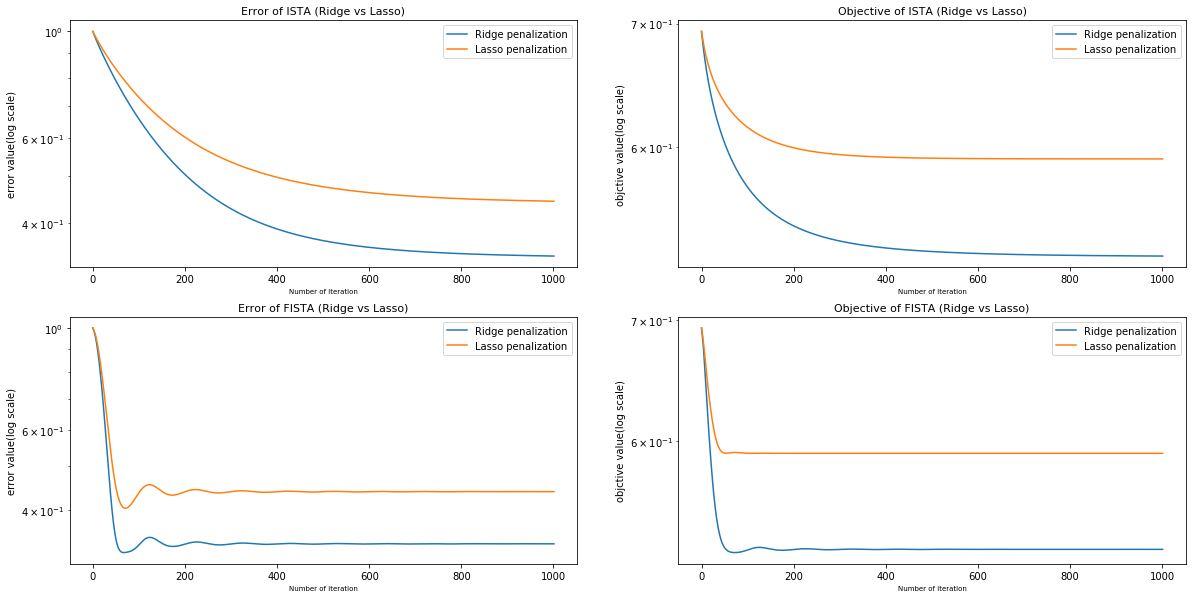

In [36]:
# ista
_, objectives_ista_logreg, errors_ista_logreg = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_logreg(A2), s=s, n_iter=1000, verbose=False)
_, objectives_ista_logreg1, errors_ista_logreg1 = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, x_true=x_t, step= 1/lip_logreg(A2), s=s, n_iter=1000, verbose=False)

# fista
_, objectives_fista_logreg2, errors_fista_logreg2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_logreg(A1), s=s, n_iter=1000, verbose=False)
_, objectives_fista_logreg3, errors_fista_logreg3 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, x_true=x_t, step= 1/lip_logreg(A1), s=s, n_iter=1000, verbose=False)


plt.figure(figsize=(20,10))
##############################################
# Plot of the error values
plt.subplot(2,2,1)
plt.plot(errors_ista_logreg, label = 'Ridge penalization')
plt.plot(errors_ista_logreg1, label = 'Lasso penalization')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Error of ISTA (Ridge vs Lasso)', fontsize=11)
plt.xlabel("Number of iteration", fontsize=7)
plt.ylabel("error value(log scale)")

##############################################
# Plot of the objective values
plt.subplot(2,2,2)
plt.plot(objectives_ista_logreg, label = 'Ridge penalization')
plt.plot(objectives_ista_logreg1, label = 'Lasso penalization')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Objective of ISTA (Ridge vs Lasso)', fontsize=11)
plt.xlabel("Number of iteration", fontsize=7)
plt.ylabel("objctive value(log scale)")

##############################################
# Plot of the error values
plt.subplot(2,2,3)
plt.plot(errors_fista_logreg2, label = 'Ridge penalization')
plt.plot(errors_fista_logreg3, label = 'Lasso penalization')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Error of FISTA (Ridge vs Lasso)', fontsize=11)
plt.xlabel("Number of iteration", fontsize=7)
plt.ylabel("error value(log scale)")

##############################################
# Plot of the objective values
plt.subplot(2,2,4)
plt.plot(objectives_fista_logreg2, label = 'Ridge penalization')
plt.plot(objectives_fista_logreg3, label = 'Lasso penalization')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Objective of FISTA (Ridge vs Lasso)', fontsize=11)
plt.xlabel("Number of iteration", fontsize=7)
plt.ylabel("objctive value(log scale)")

In [ ]:
# x_fista, objectives_fista, errors_fista = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, x_true=x_t, step= 1/lip_linreg(A1), s=s, n_iter=1000, verbose=False)